## <center>Project 3: Decision Tree Regression and Classification</center>

**Name: Doungporn Wiwatanapataphee**<br>
**Date created:** 23 March 2021<br>

### Contents

1. [Project 1](#1) <br>
    1.1 [Data visualisation and cleaning](#1.1) <br>
    1.2 [Decision Tree Classifier (Raw)](#1.2) <br>
    1.3 [Decision Tree Classifier (Scaled)](#1.3) <br>
    1.4 [Outputs and Comparison](#1.4) <br>
2. [Project 2](#2) <br>
    2.1 [Data loading, visualisation, and data preparation](#2.1) <br>
    2.2 [Decision Tree Regressor (Raw)](#2.2) <br>
    2.3 [Decision Tree Regressor (Scaled)](#2.3) <br>
    2.4 [Support Vector Regressor](#2.4) <br>
    2.5 [Comparison, output figure](#2.5) <br>
3. [References](#References)

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### 1. Project 1 <a class="anchor" id="1"></a>

The first project aims to build two decision tree classifiers (raw and scaled) to predict the localisation site of protein (SITE) from a set of attributes. 

#### 1.1 Data visualisation and cleaning <a class="anchor" id="1.1"></a> 

Once the data is loaded, we firstly explore it using `head()`, `info()`, `value_counts()`, and `describe()` functions. The `head()` and `info()` functions tell us the general structure of the data such as how many rows and columns, are there any missing values, and column's data type. 
There are 336 entries with 9 attributes in ecoli dataset, where the last attribute is the class label stating the localisation site of protien. There is no missing data. However, there is one non-numeric type column, SEQUENCE_NUMBER, which consists of accesstion number for the SWISS-PROT database. From further exploration, this accession number is unique for each row and is not useful for classification analysis. Hence, the SEQUENCE_NUMBER column can be removed.

The `value_counts()` function is passed to the class label column `SITE` of the ecoli dataset to check whether we have imbalanced class or any class has small number of instances. For the class that is too small (<10 instances), the instances belong to theses classes are removed entirely.

Then the `describe()` function is called to generate descriptive statistics of all the (numeric) attributes. It is noticed that all the attributes' values are between 0 and 1 and shifted to have a mean of 0.5, suggesting that feature scaling might not be required. However, we will build two decision tree classifer based on both raw and scaled dataset. Also, We can see that CHG has only one value (0.5), and LIP has only two values (0.48 and 1). Therefore, these two attributes are excluded from the pair plot.

Lastly, `pairplot()` function from seaborn library is called with `hue='SITE'` and `diag_kind='hist'` options to add a semantic mapping (assign colours) for each class label SITE and force the diagonal plot to be histogram just like scatter_matrix. With colours assigned for each class label in the pair plot, we can see that some of the attributes are quite good in distinguish protien site. For instance, ALM1 and ALM2 obviously separate **im** (orange) and **imU** (green) classes from the rest. In addition, MCG noticeably divide **cp** (blue) and **pp** (purple) classes from the rest.

In [2]:
cols = ['SEQUENCE_NAME', 'MCG', 'GVH', 'LIP', 'CHG', 'AAC',
        'ALM1', 'ALM2', 'SITE']

ecoli = pd.read_csv('ecoli.data', names=cols, delim_whitespace=True)
ecoli.head()

,SEQUENCE_NAME,MCG,GVH,LIP,CHG,AAC,ALM1,ALM2,SITE
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


In [3]:
ecoli.info() # check the overall structure

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SEQUENCE_NAME  336 non-null    object 
 1   MCG            336 non-null    float64
 2   GVH            336 non-null    float64
 3   LIP            336 non-null    float64
 4   CHG            336 non-null    float64
 5   AAC            336 non-null    float64
 6   ALM1           336 non-null    float64
 7   ALM2           336 non-null    float64
 8   SITE           336 non-null    object 
dtypes: float64(7), object(2)
memory usage: 23.8+ KB


In [4]:
# Remove classes with less than 10 instances
counts = ecoli['SITE'].value_counts()
ecoli = ecoli[~ecoli['SITE'].isin(counts[counts < 10].index)]
ecoli.reset_index(drop=True, inplace=True)

In [5]:
ecoli['SITE'].value_counts() # check classes' size

cp     143
im      77
pp      52
imU     35
om      20
Name: SITE, dtype: int64

In [6]:
# Remove SEQUENCE_NAME (non-numeric attribute)
del ecoli['SEQUENCE_NAME']
ecoli.describe().T

,count,mean,std,min,25%,50%,75%,max
MCG,327.0,0.494190,0.193719,0.00,0.34,0.49,0.655,0.89
GVH,327.0,0.499939,0.149935,0.16,0.40,0.47,0.570,1.00
LIP,327.0,0.484771,0.049654,0.48,0.48,0.48,0.480,1.00
CHG,327.0,0.500000,0.000000,0.50,0.50,0.50,0.500,0.50
AAC,327.0,0.499450,0.123165,0.00,0.42,0.49,0.570,0.88
ALM1,327.0,0.497462,0.217333,0.03,0.33,0.45,0.710,1.00
ALM2,327.0,0.503119,0.206947,0.00,0.35,0.43,0.710,0.99


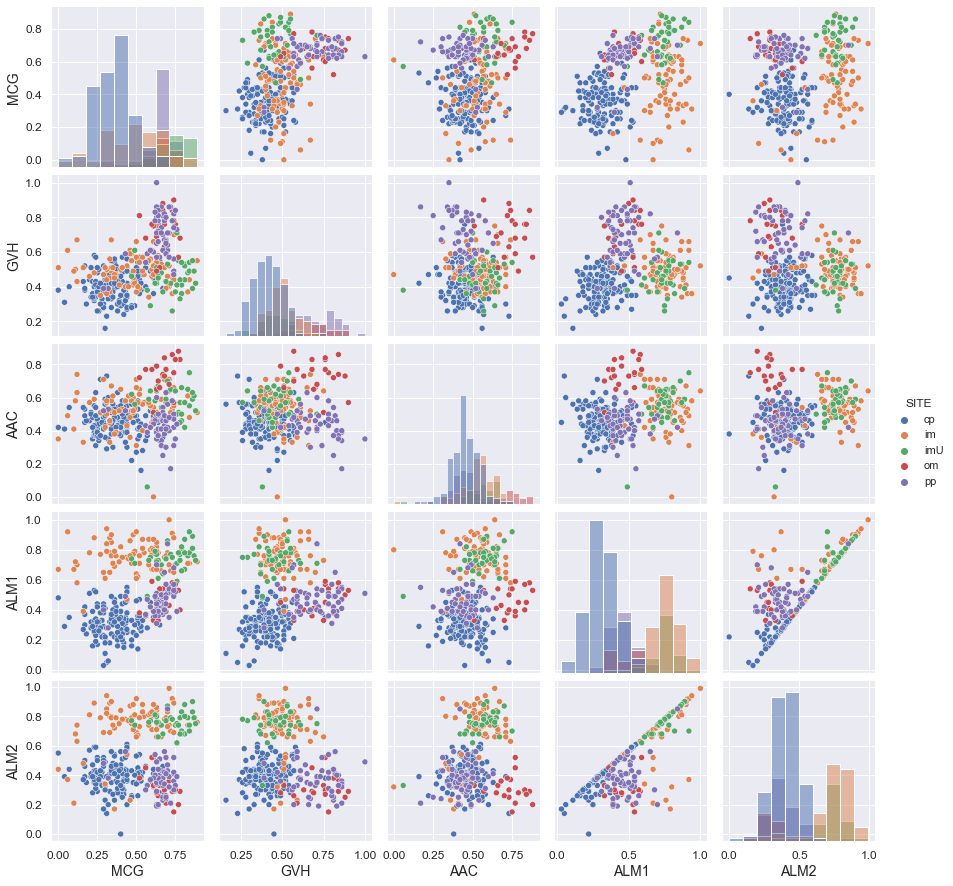

In [7]:
# Exclude LIP and CHG from pair plot
attr = ['MCG', 'GVH', 'AAC', 'ALM1', 'ALM2', 'SITE']
sns.pairplot(ecoli[attr], hue='SITE', diag_kind='hist');

#### 1.2 Decision Tree Classifier (Raw) <a class="anchor" id="1.2"></a>

We first start by extracting class label (last column) from the dataframe and naming it `y`. All other feature columns are named as `X`. Then, we split these two dataframes into 80% training and 20% test sets by using the `train_test_split()` function with `test_size=0.2` option.


Once the `DecisionTreeClassifier` and `GridSearchCV` classes are imported, the parameter grid to perfrom grid searching for is defined. Grid searching is performed on four hyperparameters:

- `criterion`: There are essentially two criterions available for decision tree classifer- namely, gini and entropy, where gini index or Gini impurity is employed as the impurity criterion by default. So, here we define parameter grid for `criterion` as a list of these two options. 
- `max_depth`: The parameter specifies the maximum depth of the tree. By default, the value are unlimitedly expanded until all the leaves are pure or contain less than min_samples_split. However, the unrestrained hyperparameter would result in the model being overfitted if the maximum depth being too high. Therefore, we start grid-searching from the minimum depth of 3 up until 5. 
- `min_samples_leaf`: The parameter specifies the minimum number of samples required to be at a leaf node. This hyperparameter is crucial in confining the shape of the decision tree, so we do not want it to be too small or too large. Hence, grid searching is performed on three values: 3, 5, and 7.
- `max_features`: The option specifies the maximum number of features to take into account when looking for the best split. The grid searching is performed on three values of max_features: 2, 4, and 6.

Also, the `random_state` is set to 42 to make the output stable across all run. In addition, the cross-validation parameter `cv` is set to 3, allowing for 3-fold cross-validated grid-search over the parameter grid.

In [8]:
# Extract labels from features
X = ecoli.iloc[:,:6]
y = ecoli.SITE

In [9]:
# Training and Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Perform grid searching
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params = {'criterion': ['gini', 'entropy'],
          'max_depth': list(range(3, 6)), # 3-5
          'min_samples_leaf': [3, 5, 7],
          'max_features': [2, 4, 6]}

dtclf_raw = GridSearchCV(DecisionTreeClassifier(random_state=42),
                          params, cv=3)
dtclf_raw.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5], 'max_features': [2, 4, 6],
                         'min_samples_leaf': [3, 5, 7]})

In [11]:
dtclf_raw.best_params_

{'criterion': 'gini', 'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 7}

Grid searching provide us with the best combination of hyperparameters as stated in `best_params_`. For the decision tree classifier of raw training set, we ended up with the Gini impurity criterion, the maximum depth of 3, the maximum features of 6, and the minimum number of sample per leaf of 7. Then, we fit the model on the training set using the obtained `best_estimator_`. 

The `cross_val_predict()` function is employed to perform 3-fold cross-validation prediction on the test data, and then the resulting confusion matrix is generated. In addition, The `classification_report()` function can be employed to generate a text report showing the main classification metrics such as precision, recall, f1-score, and accuracy.

Moreover, the decision tree can be visualised using the function `plot_tree()`.

In [12]:
# Fit the model
dtclf_raw.best_estimator_.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, max_features=6, min_samples_leaf=7,
                       random_state=42)

In [13]:
# 3-fold cross-validation prediction
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(dtclf_raw.best_estimator_, 
                           X_test, y_test, cv=3)

In [14]:
# Generate confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[28,  2,  0,  0,  0],
       [ 1, 10,  3,  0,  1],
       [ 0,  1,  3,  0,  2],
       [ 1,  0,  0,  0,  2],
       [ 4,  0,  4,  0,  4]], dtype=int64)

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

          cp     0.8235    0.9333    0.8750        30
          im     0.7692    0.6667    0.7143        15
         imU     0.3000    0.5000    0.3750         6
          om     0.0000    0.0000    0.0000         3
          pp     0.4444    0.3333    0.3810        12

    accuracy                         0.6818        66
   macro avg     0.4674    0.4867    0.4690        66
weighted avg     0.6572    0.6818    0.6634        66



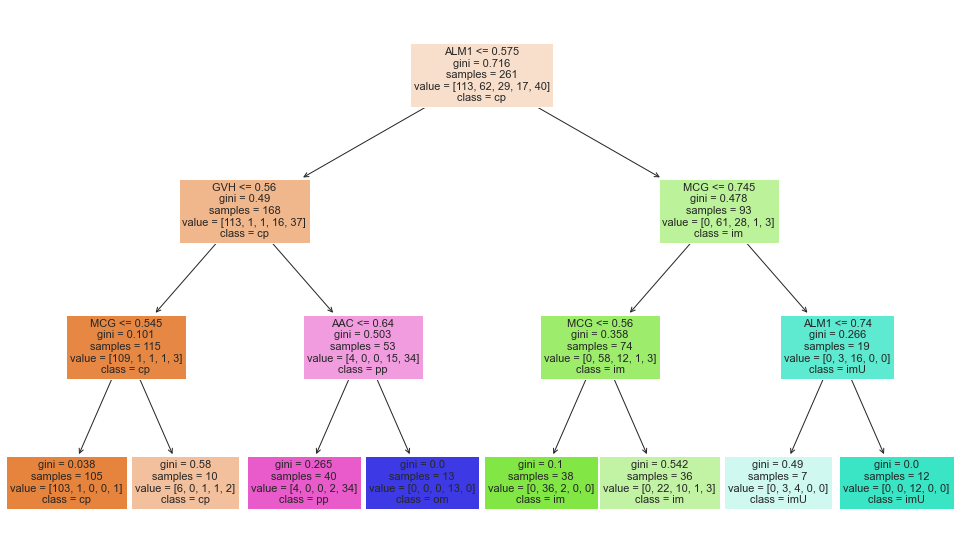

In [16]:
# Plot decision tree
from sklearn.tree import plot_tree

plt.figure(figsize=(17,10))
plot_tree(dtclf_raw.best_estimator_,
          feature_names=list(X.columns),
          class_names=[str(s) for s in y.unique()],
          filled=True,
          fontsize=11);

By observing the classification report, it is noticed that the classes with small number of instances seem to have significantly lower precision and recall as compared to other majority classes, especially the **om** class which obtain zero score for all metrics. On the other hand, the classes with relatively large number of instances obtain comparitively high precision and recall. To investigate both metrics at the same time, we can have a look at the harmonic mean of precision and recall, which is also known as F1 score. To obtain a high F1 score, both precision and recall have to be high. It is obvious that the majority classes (**cp** and **im**) obtain significantly higher F1 than the other minority classes.

The macro-average F1-score is not weighted, while the weighted-average F1-score is computed with regards to the number of instances belong to each class. Thus, the effect of imbalanced class makes the weighted average F1-score (0.66) higher than the macro average (0.47) one. However, they are both quite low even for an imbalanced dataset.

The plot of decision tree illustrates how the tree is splited based on the training data. From the top, if a sample satisfied the condition, i.e. ALM1 <= 0.575, then it goes to the left child node; otherwise it goes to the right child node. The same logic is employed until it reaches the leaf node at the bottom. Inside every node (box), there is also an information regarding the Gini impurity index, the total number of samples at each node, the number of samples belongs to each class, and the class of each node, respectively.

#### 1.3 Decision Tree Classifier (Scaled) <a class="anchor" id="1.3"></a>

In this section, we build another decision tree classifier based on scaled data. Firstly, the `StandardScaler()`, `fit_transform()` and `transform()` functions are employed to scaled the training and test datasets as in the following code cell.

Secondly, the `GridSearchCV()` and `DecisionTreeClassifier` functions are used to perform grid searching on the same parameter grid defined in the previous section. Then, the `fit` function is called to train the classifier on the scaled training set.

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [18]:
# Same parameter grid
dtclf_scale = GridSearchCV(DecisionTreeClassifier(random_state=42),
                          params, cv=3)
dtclf_scale.fit(X_train_scale, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5], 'max_features': [2, 4, 6],
                         'min_samples_leaf': [3, 5, 7]})

In [19]:
dtclf_scale.best_params_

{'criterion': 'gini', 'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 7}

For the decision tree classifier of scaled training set, we ended up with the Gini impurity criterion, the maximum depth of 3, the maximum features of 6, and minimum number of sample per leaf of 7. Notice that the best combination of hyparamenters obtained for the scaled training set is essentially the same as that of the raw training set. Again, we fit the model using the obtained best combination of hyperparameters, carry out 3-fold cross-validation prediction on the test data, and then generate the corresponding confusion matrix and classification report.

In addition, the decision tree is visualised using the function `plot_tree()`.

In [20]:
# Fit the model
dtclf_scale.best_estimator_.fit(X_train_scale, y_train)

DecisionTreeClassifier(max_depth=3, max_features=6, min_samples_leaf=7,
                       random_state=42)

In [21]:
# 3-fold cross-validation prediction
y_pred_scale = cross_val_predict(dtclf_scale.best_estimator_, 
                           X_test_scale, y_test, cv=3)

In [22]:
# Generate confusion matrix
confusion_matrix(y_test, y_pred_scale)

array([[29,  1,  0,  0,  0],
       [ 1, 10,  3,  0,  1],
       [ 0,  1,  3,  0,  2],
       [ 1,  0,  0,  0,  2],
       [ 4,  0,  4,  0,  4]], dtype=int64)

In [23]:
print(classification_report(y_test, y_pred_scale, digits=4))

              precision    recall  f1-score   support

          cp     0.8286    0.9667    0.8923        30
          im     0.8333    0.6667    0.7407        15
         imU     0.3000    0.5000    0.3750         6
          om     0.0000    0.0000    0.0000         3
          pp     0.4444    0.3333    0.3810        12

    accuracy                         0.6970        66
   macro avg     0.4813    0.4933    0.4778        66
weighted avg     0.6741    0.6970    0.6773        66



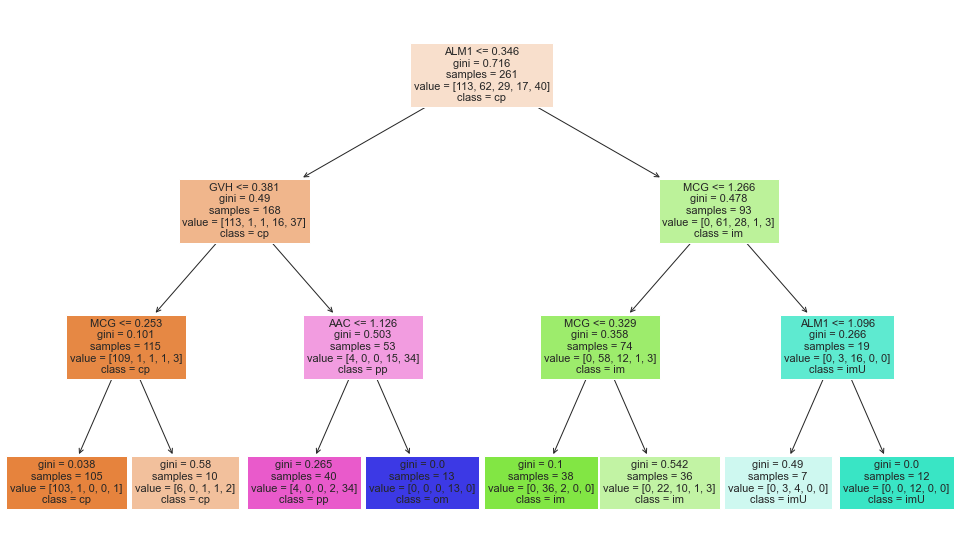

In [24]:
# Plot decision tree
plt.figure(figsize=(17,10))
plot_tree(dtclf_scale.best_estimator_,
          feature_names=list(X.columns),
          class_names=[str(s) for s in y.unique()],
          filled=True,
          fontsize=11);

The results in this section is quite similar to what we previously obtained. A comparison and discussion of the results will be given in the next section.

#### 1.4 Outputs and Comparison <a class="anchor" id="1.4"></a>

In [25]:
# Classfication report of decision tree classifier trained on raw data 
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

          cp     0.8235    0.9333    0.8750        30
          im     0.7692    0.6667    0.7143        15
         imU     0.3000    0.5000    0.3750         6
          om     0.0000    0.0000    0.0000         3
          pp     0.4444    0.3333    0.3810        12

    accuracy                         0.6818        66
   macro avg     0.4674    0.4867    0.4690        66
weighted avg     0.6572    0.6818    0.6634        66



In [26]:
# Classfication report of decision tree classifier trained on scaled data 
print(classification_report(y_test, y_pred_scale, digits=4))

              precision    recall  f1-score   support

          cp     0.8286    0.9667    0.8923        30
          im     0.8333    0.6667    0.7407        15
         imU     0.3000    0.5000    0.3750         6
          om     0.0000    0.0000    0.0000         3
          pp     0.4444    0.3333    0.3810        12

    accuracy                         0.6970        66
   macro avg     0.4813    0.4933    0.4778        66
weighted avg     0.6741    0.6970    0.6773        66



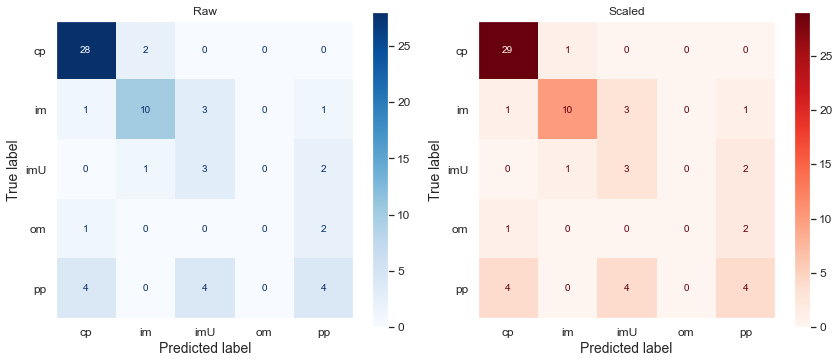

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

labels = ['cp', 'im', 'imU', 'om', 'pp']
cm_raw = confusion_matrix(y_test, y_pred)
cm_scale = confusion_matrix(y_test, y_pred_scale)
disp_raw = ConfusionMatrixDisplay(cm_raw, display_labels=labels)
disp_scale = ConfusionMatrixDisplay(cm_scale, display_labels=labels)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
disp_raw.plot(ax=axes[0], cmap='Blues')
axes[0].title.set_text('Raw')
axes[0].grid(False)
disp_scale.plot(ax=axes[1], cmap='Reds')
axes[1].title.set_text('Scaled')
axes[1].grid(False)
plt.tight_layout()
plt.show()

From the classification report of both classifiers, there is a slight difference in precision, recall, and F1 score for the majority classes **cp** and **im**. On the other hand, both classifiers obtain the same value of metrics in the minority classes: **imU**, **om**, and **pp**. 

It is noticed that about two-third of protein samples of class **pp** were equally classified to class **cp** and **imU**, which suggests that these three classes share some common characterisitics. From the pair plot and decision tree plot, we can see that protein samples of class **cp** and **pp** have a comparitively low ALM1 and ALM2. In addition, the protein samples of class **pp** and **imU** seem to have a relatively high MCG.

Also, about one-fifth of protein samples of class **im** were wrongly classified to class **imU**, and about one-sixth of protein samples of class **imU** were wrongly classified to class **im**. This suggests that these two classes also share some common traits. From the data description, both of these two classes specify the localisation site of protein inside the membrane. By observing the pair plot and the decision tree plot, it is noted that proteins of class **im** and **imU** have relatively high ALM1 and ALM2.

Apart from those finding, the results obtained from both classifiers are quite similar, which is expected. From the data exploration section, we have already noticed that all the variables have been normalised so that their values are between 0 and 1, and their mean equals to 0.5. This suggests that feature scaling may not be required in the first place.

To evaluate the performance of both classifiers, we have a look at their F1 scores. If all the classes (both majority and minortiy) are equally important, we would suggest the classifier with higher macro average F1 score. In contrast, if the majority classes are considered to be more important, the classifier with higher weighted average F1 score is preferred. As a result, the decision tree classifier which is trained on the scaled data slightly outperform the classifier which is trained on the raw data in predicting the majority class. Nonetheless, using these two classifiers to predict the minority classes is still not recommended, as the classes' F1 score is excessively low.  

With imbalanced dataset, we might as well make use of oversampling to efficiently handle imbalanced classes and possibly obtain a better classification rate. To do so, the SMOTE (Synthetic Minority Over-sampling Technique) function from imbalanced-learn library can be employed to the training set. However, it is beyond the scope of the lab.

### 2. Project 2 <a class="anchor" id="2"></a>

The second project aims to build three regressors, decision tree regressor trained on raw data, decision tree regressor trained on scaled data, and support vector regressor trained on scaled data, to predict the compressive strength of the concrete based on seven input variables from concrete slump test data.

#### 2.1 Data loading, visualisation, and data preparation <a class="anchor" id="2.1"></a>

Once the data is loaded, we firstly drop three unused columns- namely, **No**, **SLUMP(cm)**, and **FLOW(cm)**. Then, the `info` function is employed to check for NAs and the data type of each column. The output shows us that there is no NAs, and all the features are of float type.

In order to determine whether feature scaling is neccessary, the `describe()` function is used to generate the descriptive statistics of the dataframe. It is noticed that all the features have different range, suggesting the requirement of feature scaling to avoid bias in the regression analysis.

Next, the pair plot is visualised to illustrate the shape of the distribution of each feature, and the relationship between each of the variable pair including the output variable. Also, the boxplot of each of the variables are displayed.  

It is noted that the variable **Cement**, **Slag**, and **Fly ash** are bimodal distributed, while the variable **SP** is strongly right-skewed. By using the same y-axis for the boxplots, we can see that the values of **Coarse Aggr** and **Fine Aggr** are considerably high as compared to other variables. These observations suggest that data transformation and feature scaling might be required.

Then, the feature matrix **X** and ground truth **y** are extracted, and then splited into training (80%) and test (20%) set using the `train_test_split()` function.

Lastly, modularised function to carry out grid-searching, training, and evaluating the three regressors are written. More details will be given at the end of this preparation section.

The code to perform the tasks are shown as follows:

In [28]:
cst = pd.read_csv('slump_test.data', sep=',')
cst.head()

,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


In [29]:
# drop unused columns
cst = cst.drop(['No','SLUMP(cm)','FLOW(cm)'], axis=1)

In [30]:
cst.info() # check for NAs and data type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Cement                              103 non-null    float64
 1   Slag                                103 non-null    float64
 2   Fly ash                             103 non-null    float64
 3   Water                               103 non-null    float64
 4   SP                                  103 non-null    float64
 5   Coarse Aggr.                        103 non-null    float64
 6   Fine Aggr.                          103 non-null    float64
 7   Compressive Strength (28-day)(Mpa)  103 non-null    float64
dtypes: float64(8)
memory usage: 6.6 KB


In [31]:
cst.describe().T # descriptive statistics

,count,mean,std,min,25%,50%,75%,max
Cement,103.0,229.894175,78.877230,137.00,152.00,248.00,303.900,374.00
Slag,103.0,77.973786,60.461363,0.00,0.05,100.00,125.000,193.00
Fly ash,103.0,149.014563,85.418080,0.00,115.50,164.00,235.950,260.00
Water,103.0,197.167961,20.208158,160.00,180.00,196.00,209.500,240.00
SP,103.0,8.539806,2.807530,4.40,6.00,8.00,10.000,19.00
Coarse Aggr.,103.0,883.978641,88.391393,708.00,819.50,879.00,952.800,1049.90
Fine Aggr.,103.0,739.604854,63.342117,640.60,684.50,742.70,788.000,902.00
Compressive Strength (28-day)(Mpa),103.0,36.039417,7.838232,17.19,30.90,35.52,41.205,58.53


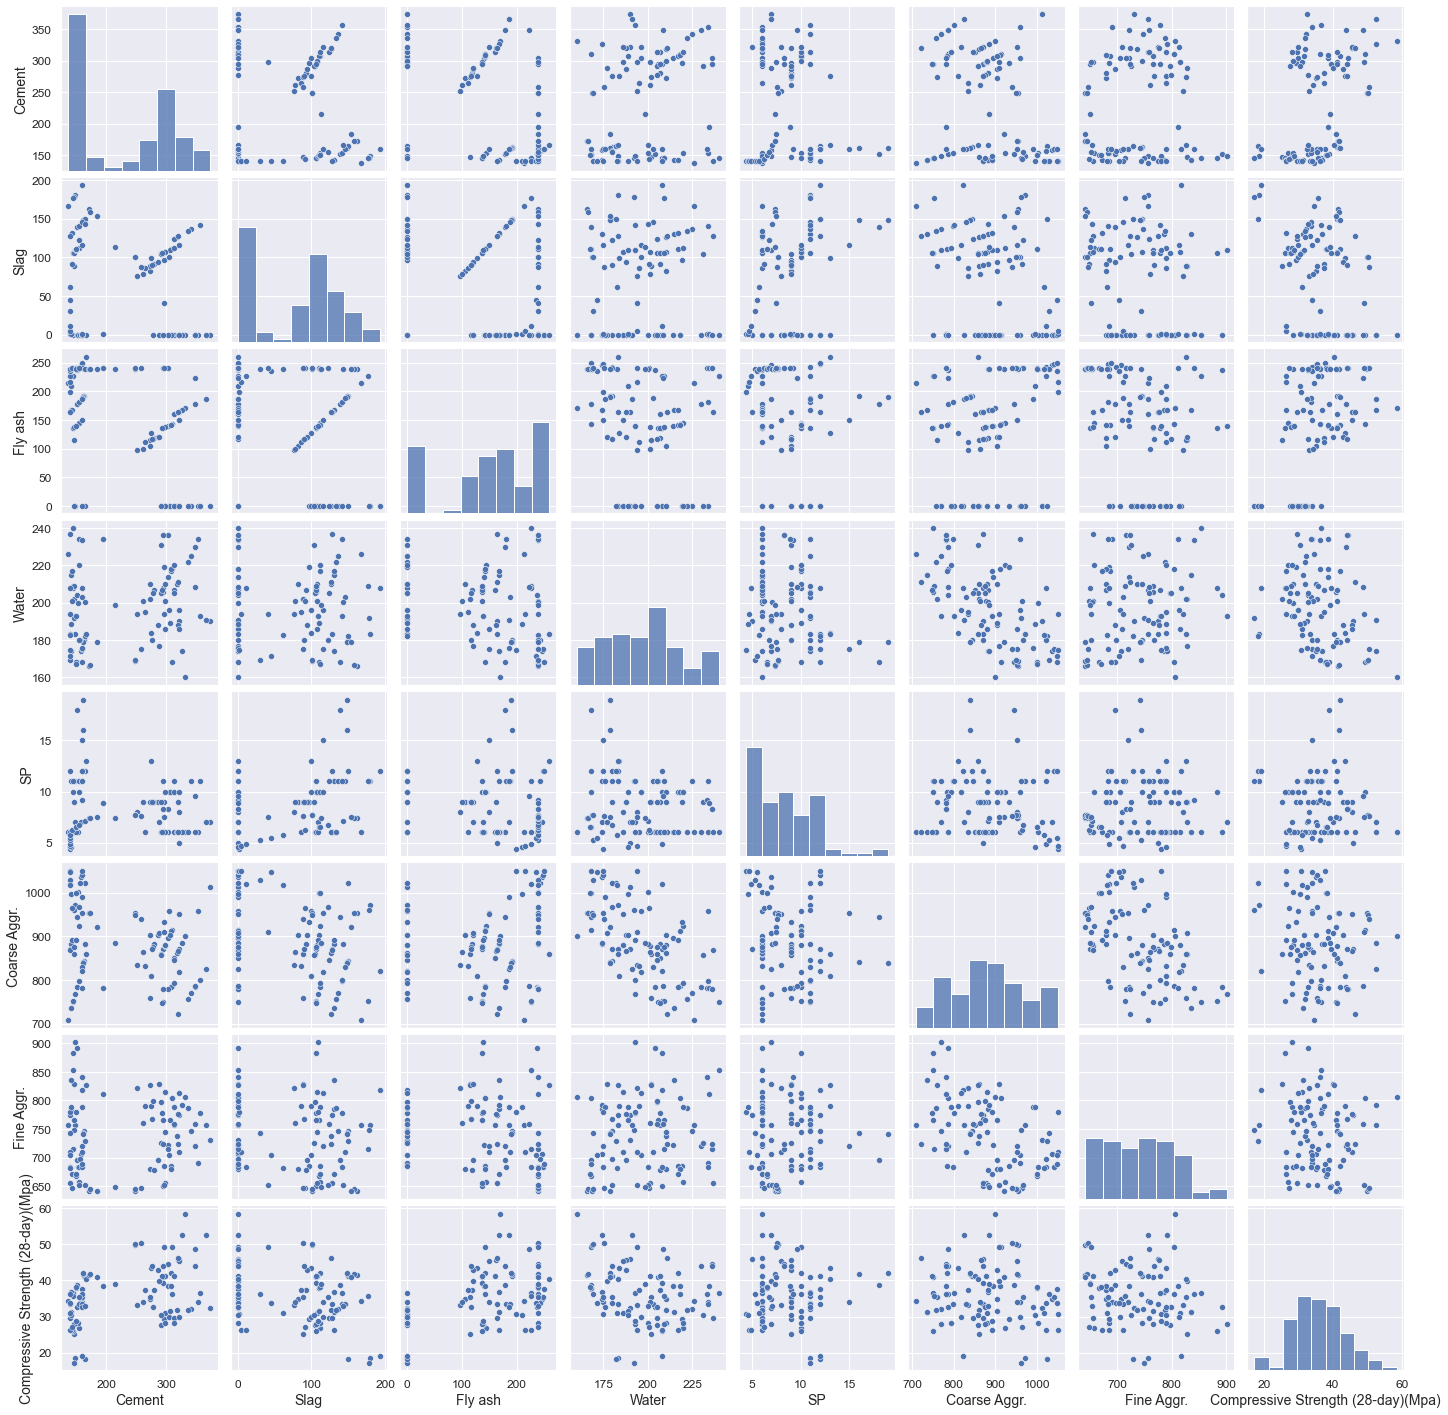

In [32]:
sns.pairplot(cst, diag_kind='hist'); # pair plot

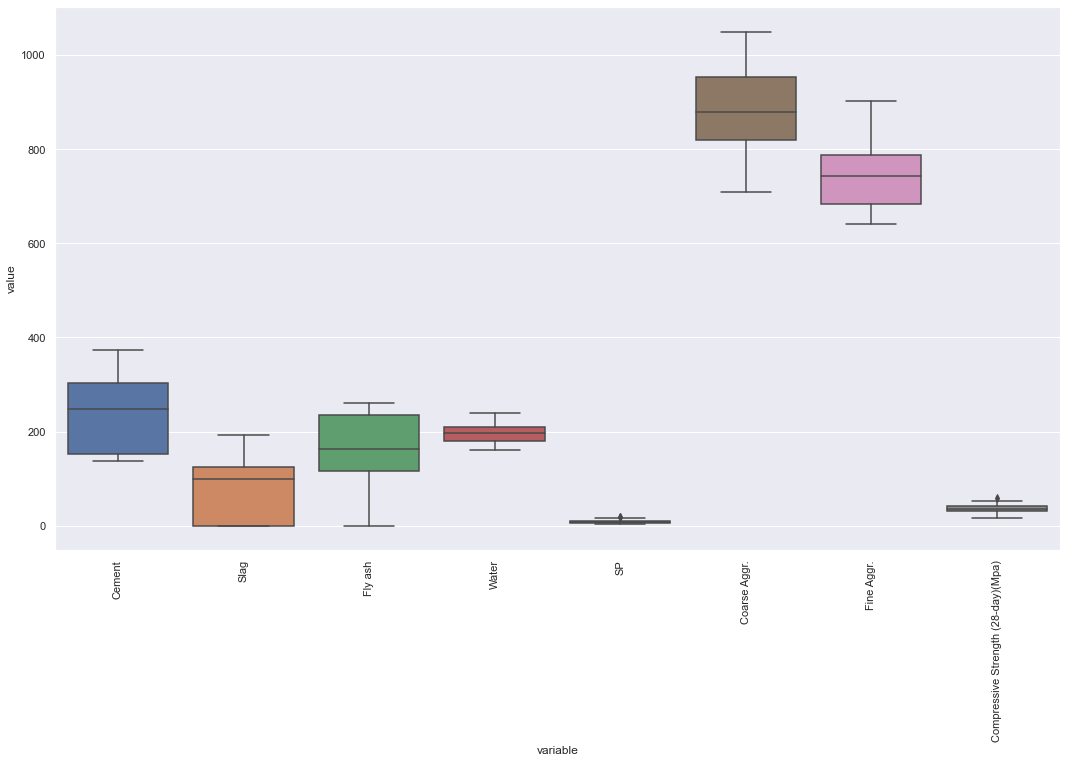

In [33]:
# boxplot
sns.set(rc={'figure.figsize':(18,10)})
bplot = sns.boxplot(x="variable", y="value", data=pd.melt(cst));
plt.setp(bplot.get_xticklabels(), rotation=90);

In [34]:
# Extract feature matrix X from ground truth y
X = cst.iloc[:,:7]
y = cst['Compressive Strength (28-day)(Mpa)']

In [35]:
# Training and Test dataset split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Feature scaling
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [37]:
# Modularised code to carry out search, fit, evaluate three regressors

# Import functions
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Decision Tree Regressor's Parameter Grid
CART_params = {'min_samples_leaf': [1, 2, 3],
               'max_depth': [3, 4, 5],
               'max_features': [2, 4, 6]}

# SVR's Parameter Grid
SVR_params = {'kernel': ['linear', 'poly', 'rbf'],
             'C': [1, 10, 100],
             'gamma': [0.1, 0.15, 0.2]}

# Define new function
def search_fit_eval_regs(reg, X_train, X_test, y_train, y_test):
    # Determine method and parameter grid
    if reg == 'CART_RAW' or reg == 'CART_SCALED':
        # Use mse criterion
        regressor = DecisionTreeRegressor(criterion='mse', random_state=42)
        params = CART_params
    elif reg == 'SVR':
        regressor = SVR()
        params = SVR_params
    else:
        print('No such method available for this function!')
    
    # Perform grid-searching on parameter grid
    grid_obj = GridSearchCV(regressor, param_grid=params, cv=3, scoring='neg_mean_squared_error')
    grid_fit = grid_obj.fit(X_train, y_train)
    # Obtain the best combination of hyperparameters
    best_reg_estimator = grid_fit.best_estimator_
    # Prediction based on the best model
    y_pred = cross_val_predict(best_reg_estimator, 
                           X_test, y_test, cv=3)
    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred) 
    # Return results
    return {'Regressor' : reg,
            'model' : best_reg_estimator,
            'Parameters' : grid_fit.best_params_,
            'Predictions' : y_pred,
            'MSE' : mse}

The above code cell shows the newly created function `search_fit_eval_regs()`, which implements the grid-searching, training, and evaluating of two types of regressors: DecisionTreeRegressor and SVR. From the top of the code cell, we start by importing the required functions and then defining the parameter grid for both methods. More details on the parameter grids will be given in section 2.2 (CART) and 2.4 (SVR).

Next, the function to perform the tasks are written. The function takes in 5 parameters- namely `reg`, `X_train`, `X_test`, `y_train`, and `y_test`. The `reg` parameter tells the function what method to be carry out, and the function will only evaluate three value of `reg`: 'CART_RAW', 'CART_SCALED', and 'SVR'. The other parameters essentially tells the function which data will be employed as a training and test set.

Firstly, we start by determining the method and parameter grid using a simple if-elif-else statement. It is noted that we use `mse` as a `criterion` for the decision tree regressors. Then, the 3-fold cross-validated grid searching is performed using the `neg_mean_squared_error` as `scoring`. The best combination of hyperparameters are employed to train the data using the training dataset. Then, 3-fold cross-validated prediction is obtained using the `cross_val_predict()` function based on the test dataset, and the `mean_squared_error()` function is applied to compute the mean squared error of the prediction of the regressor.

The function essentially return five values in dictionary format. The `Regressor` key stores the name as specified by `reg`. The `model` key stores the regressor function together with the best combination of hyperparameters. The `Parameters` contains the combination of hyperparameters used in the model. Then, the `Predictions` and `MSE` keys store the prediction values and the mean squared error of the prediction, respectively.

#### 2.2 Decision Tree Regressor (Raw) <a class="anchor" id="2.2"></a>

In this section, we make use of the newly defined function `search_fit_eval_reg()` to carry out grid-searching, training, and evaluating the decision tree regressor trained on the raw data set.

The grid searching is performed on the parameter grid consisting of three hyperparameters:

- min_samples_leaf parameter specifies the minimum number of instances required at a leaf node. The default value is 1, so we try grid searching on another two values, which are 2 and 3.
- max_depth parameter tells the maximum tree's depth. If the maximum depth being too high, the model is possibly overfitted. Therefore, we start grid-searching from the depth of 3 to 5 to avoid the possibility of overfitting.
- max_features parameter specifies the maximum number of features to take into account when looking for the best split. Since the data has only 8 input variables, we don't want the maximum number of features to exceed that and also do not want it to be too high. Thus, the grid searching is performed on three values: 2, 4, and 6.

The function `search_fit_eval_regs()` is called, and the results are stored in the list `results` for future use.

In [38]:
results = []
CART_RAW_RES = search_fit_eval_regs('CART_RAW', X_train, X_test, y_train, y_test)
results.append(CART_RAW_RES)
results[0].get('Parameters') # get hyperparameters

{'max_depth': 5, 'max_features': 6, 'min_samples_leaf': 3}

In [39]:
results[0].get('MSE') # get MSE

67.48857303439152

For the decision tree regressor trained on raw data, the best combination of hyperparameters obtained from grid searching are the maximum depth of 5, the maximum features of 6, and minimum number of samples per leaf of 3. In addtion, the mean squared error of the prediction of the regressor is computed as shown in the above code cell.

#### 2.3 Decision Tree Regressor (Scaled) <a class="anchor" id="2.3"></a>

The same process is carried out in this section. The only difference is that we use the scaled data instead of the raw data.

In [40]:
CART_SCALED_RES = search_fit_eval_regs('CART_SCALED', X_train_scale, X_test_scale, y_train, y_test)
results.append(CART_SCALED_RES)
results[1].get('Parameters') # get hyperparameters

{'max_depth': 5, 'max_features': 6, 'min_samples_leaf': 3}

In [41]:
results[1].get('MSE') # get MSE

67.48857303439152

For the decision tree regressor trained on scaled data, the best combination of hyperparameters obtained from grid searching and the mean squared error of the prediction of the regressor are essentially the same.

#### 2.4 Support Vector Regressor <a class="anchor" id="2.4"></a>

For SVR, the grid searching is performed on the parameter grid consisting of three hyperparameters:

- kernel parameters specifies the kernel type to be employed in the algorithm. The default kernel is rbf. However, from the exploratory analysis we can see a slight chance that the variables might have linear or polynomial kernel. Therefore, grid searching is performed on three kernels- namely, linear, poly, and rbf.
- C or regularisation parameter determines the strength of regularisation using the squared l2 penalty. The default value is 1, and grid searching for C value is usually performed using a list of a power of 10s. Hence, the parameter grid for C is a list of 1, 10, and 100.
- gamma parameter specifies the kernel coeffient if the kernel 'poly' or 'rbf' is chosen. The default gamma parameter is computed from the formula 1 / (n_features * X.var()), which in this case equal to around 0.15. So, we include 0.15 in grid searching with two other values 0.1 and 0.2.


In [42]:
SVR_RES = search_fit_eval_regs('SVR', X_train_scale, X_test_scale, y_train, y_test)
results.append(SVR_RES)
results[2].get('Parameters') # get hyperparameters

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

In [43]:
results[2].get('MSE') # get MSE

13.703399066328577

For the support vector regressor trained on scaled data, the best combination of hyperparameters obtained from grid searching are the RBF kernel, C = 100, and gamma = 0.1. Also, the mean squared error of the prediction of the regressor is computed as shown in the above code cell.

#### 2.5 Comparison, output figure <a class="anchor" id="2.5"></a>

In this section, the table containing the mean squared error of the three regressors for predicting the compressive strength of the concrete are shown together with the plots of the predictions versus the actual values of compressive strength.

It is obvious that the both of the Decision Tree Regressors ended up with a much worse MSE than the Support Vector Regressor, suggesting that the Support Vector Machine (SVM) method is better than Decision Tree in this study.

| Regressor     | MSE for Compressive strength |
|:--------------|-----------------------------:|
| CART (RAW)    | 67.4886                      |
| CART (SCALED) | 67.4886                      |
| SVR (SCALED)  | 13.7034                      |

In [44]:
def plot_actual_vs_predict(index):
    plt.figure(figsize=(4,4))
    plt.scatter(results[index].get('Predictions'), y_test)
    p1 = max(max(results[index].get('Predictions')), max(y_test))
    p2 = min(min(results[index].get('Predictions')), min(y_test))
    plt.plot([p1, p2], [p1, p2])
    plt.xlabel('Compressive strength prediction (Mpa)', fontsize=11)
    plt.ylabel('Compressive strength (Mpa)', fontsize=11)
    plt.title(results[index].get('Regressor'), fontsize=11);

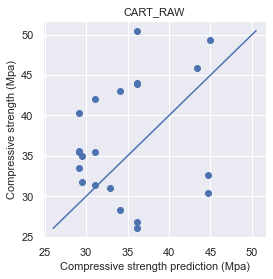

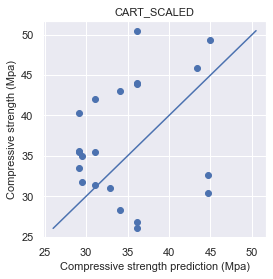

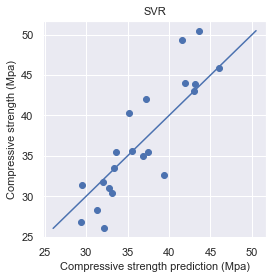

In [45]:
plot_actual_vs_predict(0)
plot_actual_vs_predict(1)
plot_actual_vs_predict(2)